# Introduction

### 1.1 Import Libraries and Data

In [80]:
import pandas as pd # for data frames
import numpy as np # for numerical calculation
import warnings # for ignoring warning
from functools import reduce # for reduce function
from scipy import stats # for statistical analysis
from country_list import countries_for_language # for country list
from sklearn.preprocessing import OneHotEncoder # for one hot encoding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

# for inline plotting
%matplotlib inline 

# remove warning
warnings.filterwarnings('ignore')

In [81]:
# read the data
sheet1 = pd.read_excel(io="./data.xls", sheet_name="GDP", names=["Name","Code","GDP2015","GDP2016","GDP2017"])
sheet2 = pd.read_excel(io="./data.xls", sheet_name="Total_Population", names=["NameA","Code","TP2015","TP2016","TP2017"])
sheet3 = pd.read_excel(io="./data.xls", sheet_name="Female_Population_Percentage", names=["NameB","Code","FPP2015","FPP2016","FPP2017"])
sheet4 = pd.read_excel(io="./data.xls", sheet_name="Countries", names=["Code","Region","IncomeGroup","Note","NameC"])

# create single DataFrame
df = reduce(lambda left,right: pd.merge(left,right, on=["Code"]), [sheet1, sheet2, sheet3, sheet4])
# print head of dataframe   
df.head()

,Name,Code,GDP2015,GDP2016,GDP2017,NameA,TP2015,TP2016,TP2017,NameB,FPP2015,FPP2016,FPP2017,Region,IncomeGroup,Note,NameC
0,Afghanistan,AFG,1.990711e+10,1.936264e+10,2.019176e+10,Afghanistan,34413603.0,35383128.0,36296400.0,Afghanistan,48.607049,48.599668,48.611616,South Asia,Low income,NaN,Afghanistan
1,Albania,ALB,1.138693e+10,1.186135e+10,1.302506e+10,Albania,2880703.0,2876101.0,2873457.0,Albania,49.093798,49.052999,49.046398,Europe & Central Asia,Upper middle income,NaN,Albania
2,Algeria,DZA,1.659793e+11,1.601299e+11,1.675553e+11,Algeria,39728025.0,40551404.0,41389198.0,Algeria,49.496877,49.491505,49.487380,Middle East & North Africa,Upper middle income,NaN,Algeria
3,American Samoa,ASM,6.610000e+08,6.530000e+08,6.340000e+08,American Samoa,55812.0,55741.0,55620.0,American Samoa,NaN,NaN,NaN,East Asia & Pacific,Upper middle income,NaN,American Samoa
4,Andorra,AND,2.811489e+09,2.877312e+09,3.013387e+09,Andorra,78011.0,77297.0,77001.0,Andorra,NaN,NaN,NaN,Europe & Central Asia,High income,NaN,Andorra


## Female Population data based on female population percentage 

In [82]:
#creating female population data based on female population percentage 
df["FP2015"] = df.apply(lambda row: (row.TP2015*row.FPP2015)/100, axis=1)
df["FP2016"] = df.apply(lambda row: (row.TP2016*row.FPP2016)/100, axis=1)
df["FP2017"] = df.apply(lambda row: (row.TP2017*row.FPP2017)/100, axis=1)

## Male Population data based on Female Population

In [83]:
#creating male population data based on female population
df["MP2015"] = df.apply(lambda row: (row.TP2015-row.FP2015), axis=1)
df["MP2016"] = df.apply(lambda row: (row.TP2016-row.FP2016), axis=1)
df["MP2017"] = df.apply(lambda row: (row.TP2017-row.FP2017), axis=1)

In [84]:
# droping the unwanted columns
df.drop(["FPP2015","FPP2016","FPP2017","NameA","NameB","NameC"], axis=1, inplace=True)

List of all countries with names(ISO 3166-1) are imported and cross dataed with DataSet_df country name to understand the relationship between the country and other variables. 


In [85]:
#fetching country list
countries = list(dict(countries_for_language('en')).values())

#defining clean dataframe based on recognised country name
data = df[df["Name"].isin(countries)]
other = df[~df["Name"].isin(countries)]

#defining new views of the data
Y2015 = data[["Name","Code","GDP2015","TP2015","FP2015","MP2015"]]
Y2016 = data[["Name","Code","GDP2016","TP2016","FP2016","MP2016"]]
Y2017 = data[["Name","Code","GDP2017","TP2017","FP2017","MP2017"]]
GDP   = data[["Name","Code","GDP2015","GDP2016","GDP2017","Region","IncomeGroup","Note"]]

#creating mapper for IncomeGroup
IncomeGroupMapper = {"High income":4,
                     "Upper middle income":3,
                     "Lower middle income":2,
                     "Low income":1,
                     }
                     
#mapping IncomeGroup based on IncomeGroupMapper
data.replace({"IncomeGroup": IncomeGroupMapper}, inplace=True)

In [86]:
# shape of the data
row, column = data.shape

#calculating usefulness of DataSet_df columns
print("Usefulness % of a column in the dataset :")
round(((row - data.isnull().sum()) / row) * 100 , 2)

Usefulness % of a column in the dataset :


Name           100.00
Code           100.00
GDP2015         96.11
GDP2016         96.11
GDP2017         93.89
TP2015          99.44
TP2016          99.44
TP2017          99.44
Region         100.00
IncomeGroup    100.00
Note            28.33
FP2015          89.44
FP2016          89.44
FP2017          89.44
MP2015          89.44
MP2016          89.44
MP2017          89.44
dtype: float64

Since all of the data belong to real incidents and contain nonnumeric values, finding usefulness in percentages can help us to identify which fields should be used for analysis. Field with a lot of empty values does not provide much information about trends over time, with some exceptions. 

In [87]:
#filling NAN value with median
for columnName in ['GDP2015','GDP2016','GDP2017','TP2015','TP2016','TP2017','FP2015','FP2016','FP2017','MP2015','MP2016','MP2017']:
    data[columnName].fillna(data[columnName].median(), inplace=True)

### 1.3 General Observations

In [88]:
print("Data source contain Rows {} - Columns {}".format(data.shape[0], data.shape[1]))

Data source contain Rows 180 - Columns 17


In [89]:
country2015 = GDP[GDP["GDP2015"]==GDP["GDP2015"].max()]
country2016 = GDP[GDP["GDP2016"]==GDP["GDP2016"].max()]
country2017 = GDP[GDP["GDP2017"]==GDP["GDP2017"].max()]

print("Country with maximum GDP in 2015-{}, 2016-{}, and 2017-{}.".format(country2015["Name"].values[0],country2016["Name"].values[0],country2016["Name"].values[0]))

Country with maximum GDP in 2015-United States, 2016-United States, and 2017-United States.


In [90]:
country2015 = GDP[GDP["GDP2015"]==GDP["GDP2015"].min()]
country2016 = GDP[GDP["GDP2016"]==GDP["GDP2016"].min()]
country2017 = GDP[GDP["GDP2017"]==GDP["GDP2017"].min()]

print("Country with maximum GDP in 2015-{}, 2016-{}, and 2017-{}.".format(country2015["Name"].values[0],country2016["Name"].values[0],country2016["Name"].values[0]))

Country with maximum GDP in 2015-Tuvalu, 2016-Tuvalu, and 2017-Tuvalu.


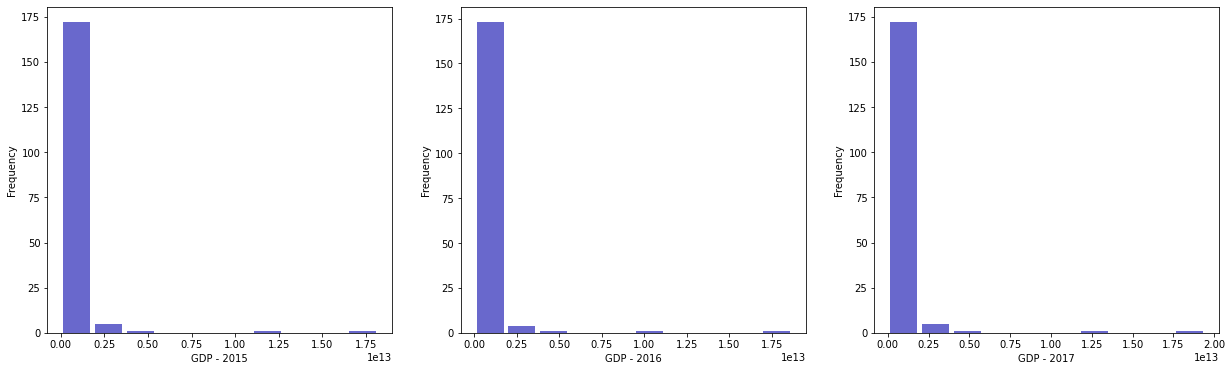

In [91]:
plt.figure(figsize=(21,6))

#Frequency vs GDP-2015
plt.subplot(1, 3, 1)
plt.hist(data["GDP2015"], color='#0504aa', alpha=0.6, rwidth=0.85)
plt.xlabel('GDP - 2015')
plt.ylabel('Frequency')

#Frequency vs GDP-2016
plt.subplot(1, 3, 2)
plt.hist(data["GDP2016"],color='#0504aa', alpha=0.6, rwidth=0.85)
plt.xlabel('GDP - 2016')
plt.ylabel('Frequency')

#Frequency vs GDP-2017
plt.subplot(1, 3, 3)
plt.hist(data["GDP2017"],color='#0504aa', alpha=0.6, rwidth=0.85)
plt.xlabel('GDP - 2017')
plt.ylabel('Frequency')

plt.show()

In [92]:
#performing transformation
for columnName in ['GDP2015','GDP2016','GDP2017','TP2015','TP2016','TP2017','FP2015','FP2016','FP2017','MP2015','MP2016','MP2017']:
    data[columnName] = data[columnName].apply(np.log)

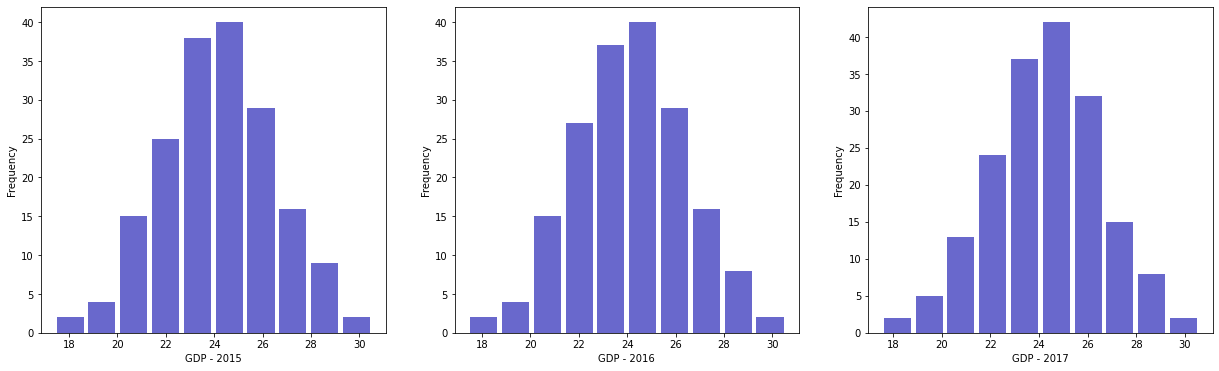

In [93]:
plt.figure(figsize=(21,6))

#Frequency vs GDP-2015
plt.subplot(1, 3, 1)
plt.hist(data["GDP2015"], color='#0504aa', alpha=0.6, rwidth=0.85)
plt.xlabel('GDP - 2015')
plt.ylabel('Frequency')

#Frequency vs GDP-2016
plt.subplot(1, 3, 2)
plt.hist(data["GDP2016"],color='#0504aa', alpha=0.6, rwidth=0.85)
plt.xlabel('GDP - 2016')
plt.ylabel('Frequency')

#Frequency vs GDP-2017
plt.subplot(1, 3, 3)
plt.hist(data["GDP2017"],color='#0504aa', alpha=0.6, rwidth=0.85)
plt.xlabel('GDP - 2017')
plt.ylabel('Frequency')

plt.show()

In [94]:
#shapiro-wilk test
stats.shapiro(data["GDP2015"].apply(np.log))

ShapiroResult(statistic=0.9934816956520081, pvalue=0.607693612575531)

**Conclusion-2**

* The Shapiro–Wilk test is a test of normality, and our result are in favour of null hypothesis i.e. data is from normal distribution.

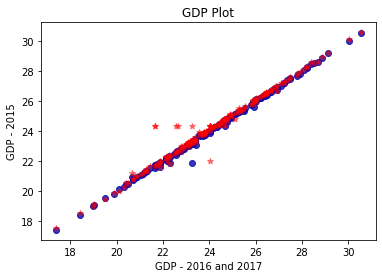

In [95]:
#ploting trend in GDP
plt.scatter(data["GDP2015"], data["GDP2016"], color='#0504aa', alpha=0.8,marker='o')
plt.scatter(data["GDP2015"], data["GDP2017"], color='red', alpha=0.5,marker='*')
plt.xlabel('GDP - 2016 and 2017')
plt.ylabel('GDP - 2015')
plt.title('GDP Plot')
plt.show()

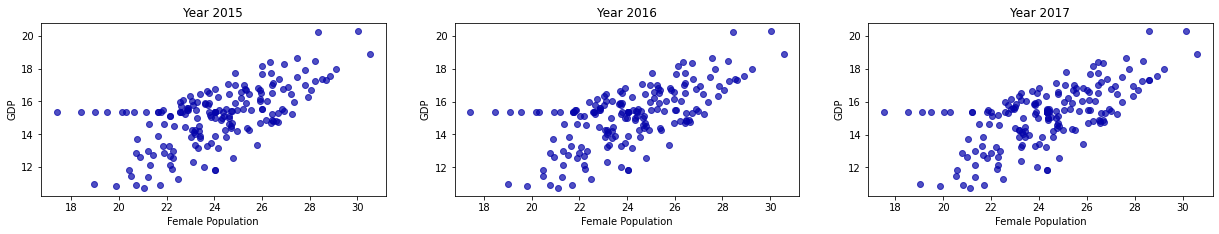

In [96]:
plt.figure(figsize=(21,7))
# plt.scatter(data["GDP2015"], data["GDP2016"], color='#0504aa', alpha=0.8,marker='o')
#female population vs GDP for Year 2015
plt.subplot(2, 3, 1)
plt.scatter(data["GDP2015"], data["FP2015"], color='#0504aa', alpha=0.7,marker='o')
plt.xlabel('Female Population')
plt.ylabel('GDP')
plt.title('Year 2015')

#female population vs GDP for Year 2016
plt.subplot(2, 3, 2)
plt.scatter(data["GDP2016"], data["FP2016"],color='#0504aa', alpha=0.7,marker='o')
plt.xlabel('Female Population')
plt.ylabel('GDP')
plt.title('Year 2016')

#female population vs GDP for Year 2017
plt.subplot(2, 3, 3)
plt.scatter(data["GDP2017"], data["FP2017"],color='#0504aa', alpha=0.7,marker='o')
plt.xlabel('Female Population')
plt.ylabel('GDP')
plt.title('Year 2017')
plt.show()

**Conclusion-3**

* Year 2015-2016-2017 have similar kind of distribution; because of the incremental nature of the countries who are performing well are showing the same type of result in consecutive years.

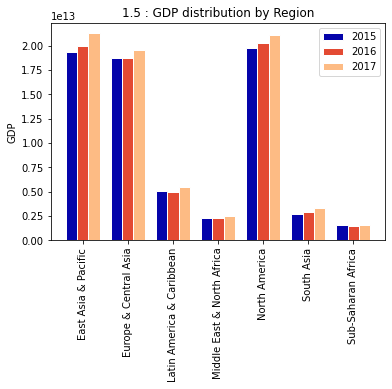

In [97]:
#set height of bar
GDP2015 = list(GDP.groupby(['Region']).sum()["GDP2015"])
GDP2016 = list(GDP.groupby(['Region']).sum()["GDP2016"])
GDP2017 = list(GDP.groupby(['Region']).sum()["GDP2017"])
 
#set position of bar on X axis
pos1 = np.arange(len(GDP2015))
pos2 = [x + 0.25 for x in pos1]
pos3 = [x + 0.25 for x in pos2]
 
#make the plot
plt.bar(pos1, GDP2015, width=0.25, edgecolor='white', label='2015', color='#0504aa')
plt.bar(pos2, GDP2016, width=0.25, edgecolor='white', label='2016', color='#e34a33')
plt.bar(pos3, GDP2017, width=0.25, edgecolor='white', label='2017', color='#fdbb84')
 
#add xticks on the middle of the group bars
plt.xticks(rotation=90)
plt.xticks([r + 0.25 for r in range(len(GDP2015))], GDP.groupby(['Region']).sum()["GDP2015"].keys())
 
#create legend and show graphic
plt.ylabel('GDP')
plt.title('1.5 : GDP distribution by Region')
plt.legend()
plt.show()

**Conclusion-4**

* GDP for all the regions is in incremental way (ie GDP-2017 > GDP-2016 > GDP-2015).
* GDP of `North America` and `Asian Region` is much higher compares with other regions; This is because `North America` is having `The United States` and `Asian Region` is having `China` which is contributing in the result.

**The strenght of the relationship - Cohen'1988**

* `No Relationship`: `r=0`
* `Small Relationship`: `0.10< r =<0.30`
* `Medium Relationship`: `0.30< r =<0.50`
* `Large Relationship`: `0.50< r =<1.00`

In [98]:
print("Correlation coffecient for Year 2015 - {}".format(np.corrcoef(data["GDP2015"], data["FP2015"])[0, 1]))

Correlation coffecient for Year 2015 - 0.641889132802393


In [99]:
print("Correlation coffecient for Year 2016 - {}".format(np.corrcoef(data["GDP2016"], data["FP2016"])[0, 1]))

Correlation coffecient for Year 2016 - 0.6386216650994351


In [100]:
print("Correlation coffecient for Year 2017 - {}".format(np.corrcoef(data["GDP2017"], data["FP2017"])[0, 1]))

Correlation coffecient for Year 2017 - 0.6443823626301776


In [101]:
stats.linregress(data["GDP2017"], data["FP2017"])

LinregressResult(slope=0.5017609227261288, intercept=2.9903797637300666, rvalue=0.6443823626301777, pvalue=1.6803699079655154e-22, stderr=0.0446309612282884, intercept_stderr=1.0885848912865945)

**Conclusion-5**

As we can see that there is `strong statistically significant relationship` between country's women population and its Gross Domastic Product.
>`rvalue = 0.64`
> `pvalue = 1.58`

### 1.4 Preparing Data

In [102]:
#normalization - minmaxscaler
for columnName in ['GDP2015','GDP2016','GDP2017','TP2015','TP2016','TP2017','FP2015','FP2016','FP2017','MP2015','MP2016','MP2017']:
    data[columnName] = (data[columnName] - data[columnName].min())/(data[columnName].max() - data[columnName].min())

#transforming data for model development
A = data[["TP2015","FP2015","GDP2015"]]
B = data[["TP2016","FP2016","GDP2016"]]
C = data[["TP2017","FP2017","GDP2017"]]

A.columns = ["TP","FP","GDP"]
B.columns = ["TP","FP","GDP"]
C.columns = ["TP","FP","GDP"]

modelData = pd.concat([A,B,C])

# Extract feature column 'Text'
X = modelData.drop(["GDP"], axis=1)
# Extract target column 'Class'
y = modelData["GDP"]

In [105]:
#Shuffle and split the dataset into the number of training and testing points
if True: 
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, train_size=0.80, random_state=42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 432 samples.
Testing set has 108 samples.


<AxesSubplot:>

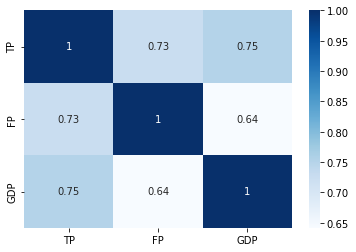

In [106]:
#corellation heatmap betweeen Total Population-Female Population-GDP
sns.heatmap(modelData.corr(),cmap="Blues",annot=True)


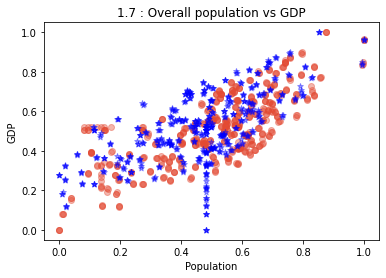

In [107]:
#plotting trend in GDP
plt.scatter(modelData["TP"], modelData["GDP"] ,color='#e34a33',marker="o",alpha=0.4)
plt.scatter(modelData["FP"], modelData["GDP"], c="blue", marker="*",alpha=0.4)
plt.xlabel('Population')
plt.ylabel('GDP')
plt.title('1.7 : Overall population vs GDP')
plt.show()

**Conclusion-6**

* There is `no extreme outliers` and shows `Homoscedasticity`.

### 1.5 Training and Evaluation

In [108]:
#import Linear Regression algorithm
from sklearn.linear_model import LinearRegression
#define Linear Regression
linear = LinearRegression()
#fit training data
linear.fit(X_train,y_train)
#test data
linear.score(X_test,y_test)

0.5916058417866801

In [109]:
m1, m2 = linear.coef_
c = linear.intercept_
line = (modelData["TP"]*m1+modelData["FP"]*m2)+ c

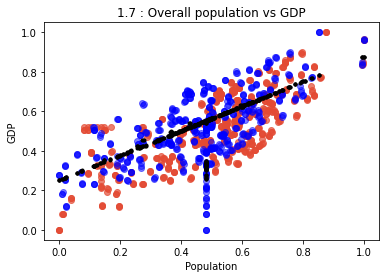

In [110]:
#ploting trend in GDP
plt.scatter(modelData["TP"], modelData["GDP"] , c="#e34a33", marker="o",alpha=0.7)
plt.scatter(modelData["FP"], modelData["GDP"], c="blue", marker="o",alpha=0.5)
plt.scatter(modelData["FP"], line, color='black',marker='.')
plt.xlabel('Population')
plt.ylabel('GDP')
plt.title('1.7 : Overall population vs GDP')
plt.show()

### As we can see, there is a strong statistically significant association between the country's female population and its GDP. We can notice a linear pattern in the data when we compare total population to GDP.
